### READ ME
This is a final project for the course 'Business Data Analytics, Quantitative Methods and Visualization' (2021, Copenhagen Business School).
The goal of this project is to be able to predict the outcome of a certain UFC fight, more specifically to predict whether the Red or Blue fighter is more likely to win the match.

We are going to do this through the following steps:
1. __Importing necessary libraries and tools.__
2. __Loading, Cleaning & Exploring the dataset.__
3. __Data pre-processing.__
4. __Machine Learning Models.__
5. __Making a prediction.__
6. __Showcasing results.__

### Legend

- ufc = the original dataset
- column_names = list of column names
- ufc_df = the dataset without NaNs
- datatypes = dictionary with column names + their datatypes
- ufc_ohe = one hot encoded dataset

# 1. Importing necessary libraries and tools.

In [1]:
# libraries

import pandas as pd #used
import matplotlib.pyplot as plt #used
import numpy as np #used
import seaborn as sns #used

# models

from sklearn.neighbors import KNeighborsClassifier #used
from sklearn.neural_network import MLPClassifier #used
from sklearn.tree import DecisionTreeClassifier #used
from sklearn.ensemble import RandomForestClassifier #used
from sklearn.preprocessing import StandardScaler 



from sklearn.preprocessing import MinMaxScaler #used
from sklearn.feature_selection import SelectKBest #used
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# use cross validation with grid search as well. 
from sklearn.model_selection import GridSearchCV

# other tools

from sklearn.model_selection import train_test_split #used
from sklearn.metrics import accuracy_score #used

import warnings #used

# 2. Loading, Cleaning & Exploring the dataset.

### 2.1 Load excel file (ufc.xlsx) and print out the first couple rows.

In [2]:
ufc = pd.read_excel('newestdataset.xlsx')

In [3]:
ufc.head()

,Unnamed: 0,R_odds_dec,B_odds_dec,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,...,R_Height_cms,R_Reach_ins,R_Reach_cms,R_Weight_lbs,R_UFC_fights,R_age,Reach_diff_ins,Age_diff,R_odds,B_odds
0,0,2.450000,1.606061,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,...,162.56,64.000000,162.56,135.0,10,32.0,3.0,1,145.0,-165.0
1,1,1.090909,8.000000,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,...,165.10,66.000000,167.64,125.0,7,31.0,0.0,1,-1100.0,700.0
2,2,1.476190,2.750000,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,...,180.34,76.000001,193.04,155.0,15,35.0,3.0,1,-210.0,175.0
3,3,4.000000,1.277778,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,...,162.56,68.000000,172.72,135.0,8,29.0,1.0,3,300.0,-360.0
4,4,1.625000,2.400000,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,...,187.96,75.000000,190.50,264.0,4,26.0,2.0,6,-160.0,140.0


### 2.2 Get number of rows and columns.

In [4]:
# print('Number of rows:', ufc.shape[0])
# print('Number of columns:', ufc.shape[1])

### 2.3 Get the list of column names.

In [5]:
column_names = ufc.columns

#### *We can call this list whenever we want to check the name of a column.*

### 2.4 Check for missing data.

In [6]:
# ufc.info()

#### As we can see, there are some NaNs in these columns that should later be taken care of:
- B_avg_SIG_STR_landed
- B_avg_SIG_STR_pct
- B_avg_SUB_ATT     
- B_avg_TD_landed      
- B_avg_TD_pct
- R_avg_SIG_STR_landed
- R_avg_SIG_STR_pct
- R_avg_SUB_ATT     
- R_avg_TD_landed      
- R_avg_TD_pct  

### 2.5 Check for duplicates.

In [7]:
duplicates = ufc.duplicated()
ufc[duplicates]

,Unnamed: 0,R_odds_dec,B_odds_dec,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,...,R_Height_cms,R_Reach_ins,R_Reach_cms,R_Weight_lbs,R_UFC_fights,R_age,Reach_diff_ins,Age_diff,R_odds,B_odds


#### *It seems that there are no duplicates, therefore, we only need to focus on NaN values.*

### 2.6 Fill NaNs with 0.

In [8]:
ufc_df = ufc.fillna(0)

print('Number of rows:', ufc_df.shape[0])
print('Number of columns:', ufc_df.shape[1])

Number of rows: 5144
Number of columns: 78


### 2.7 Check if columns have the right datatype.

In [9]:
# datatypes = ufc_df.dtypes.to_dict()
# datatypes

- O = object
- int64 = integer
- float64 = float
- <M8[ns] = date ("On a machine whose byte order is little endian, there is no difference between *np.dtype('datetime64[ns]')* and *np.dtype('<M8[ns]')*")
- bool = True/False

### 2.8 Fix datatypes if necessary.

### 2.9 Use info() again to check missing values and datatypes.

### 2.10 Create a dataframes for visualizations.

In [10]:
# General features
ufc_gen = ufc_df[['R_odds_dec', 'B_odds_dec', 'date', 'location', 'Winner', 'weight_class', 'Reach_diff_ins', 'Age_diff']]

### 2.11 Use head() for a better overview.

In [11]:
ufc_gen.head()

,R_odds_dec,B_odds_dec,date,location,Winner,weight_class,Reach_diff_ins,Age_diff
0,2.450000,1.606061,2019-06-08,"Chicago, Illinois, USA",Red,Bantamweight,3.0,1
1,1.090909,8.000000,2019-06-08,"Chicago, Illinois, USA",Red,Women's Flyweight,0.0,1
2,1.476190,2.750000,2019-06-08,"Chicago, Illinois, USA",Red,Lightweight,3.0,1
3,4.000000,1.277778,2019-06-08,"Chicago, Illinois, USA",Blue,Bantamweight,1.0,3
4,1.625000,2.400000,2019-06-08,"Chicago, Illinois, USA",Blue,Heavyweight,2.0,6


### 2.12 General features.

#### 2.12.1 Odds.

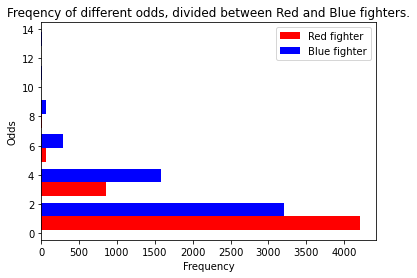

In [12]:
plt.hist(ufc_gen[['R_odds_dec', 'B_odds_dec']], color = ['Red', 'Blue'], bins = 6, orientation = 'horizontal', label = ['Red fighter', 'Blue fighter'])
plt.xlabel('Frequency')
plt.ylabel('Odds')
plt.title('Freqency of different odds, divided between Red and Blue fighters.')
plt.legend()
plt.show()

*The graph basically shows that there were approximately 2400 fights where the Red Fighter's odds were around 1-2, while there were only around 1900 where Blue Fighters had such a low odds (which means higher chance to win). However, in case of higher odds (which means less chance of winning the fight) Blue Fighters are dominating.* 

*From these, we can see that Red Fighters have lower odds in general which proves that statistically, they have higher chances to win. This seems logical as Red fighters are usually Favorites and Blue Fighters are underdogs.*

#### 2.12.2 Location.

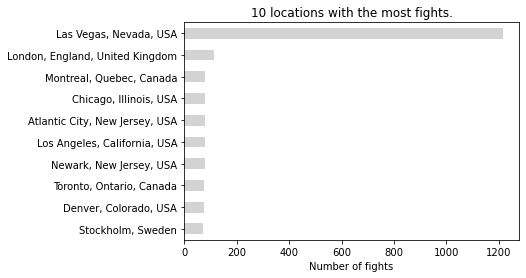

In [13]:
ufc_gen['location'].value_counts().head(10).sort_values(ascending = True).plot(kind = 'barh', color = 'Lightgrey')
plt.xlabel('Number of fights')
plt.title('10 locations with the most fights.')
plt.savefig('location.png')
plt.show()

*Seems skewed, it's worth considering leaving location out.*

#### 2.12.3 Winner.

C:\Users\gusta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


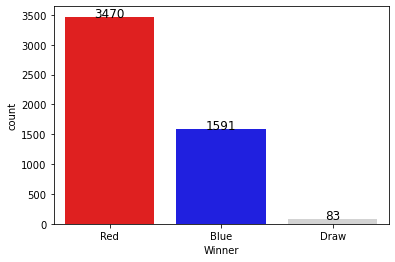

In [14]:
ax = sns.countplot(ufc_gen['Winner'], palette = ['Red', 'Blue', 'Lightgrey'])

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(), ha = 'center', va = 'baseline', color = 'black', size = 12
            )

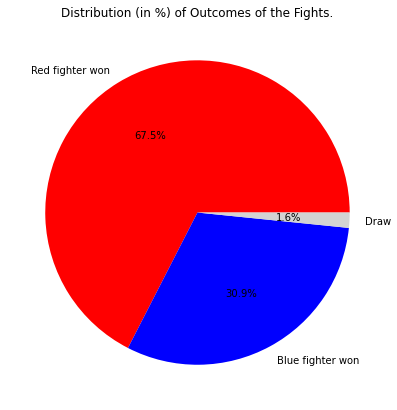

In [15]:
ufc_gen['Winner'].value_counts().plot.pie(colors = ['Red', 'Blue', 'Lightgrey'], 
                labels=['Red fighter won', 'Blue fighter won', 'Draw'], autopct='%.1f%%', figsize = (7,7))
plt.ylabel('')
plt.title('Distribution (in %) of Outcomes of the Fights.')
plt.savefig('piechart.png')
plt.show()

*Based on the 2 graphs above, we can say that Red Fighters win more often which is probably because the Red Fighter is the Favorite.*

*If 56.2% of UFC fights end with a Red-win, one could say that he should always bet on the Red Fighter for higher chances.*

*Our goal is to exceed that 56.2% with our machine learning algorithm, and to be able to make more exact and appropiate decisions.* 

#### 2.12.4 Weight class.

<AxesSubplot:xlabel='weight_class'>

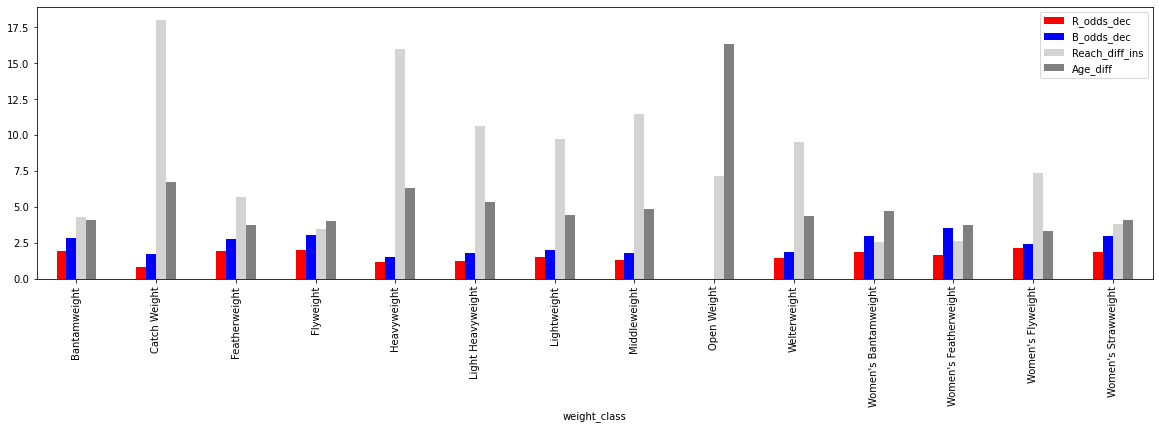

In [16]:
# would be nice to divide it to two graphs by gender

ufc_gen.groupby('weight_class').mean().plot.bar(figsize=(20,5), color = ['Red', 'Blue', 'Lightgrey', 'Grey', 'Black'])

#### *We can see that the features included in this visualization highly depend on what weight class we are talking about, therefore, we should definetely include 'weight_class' in our most important features.*

#### 2.12.5 Reach & Age Difference.

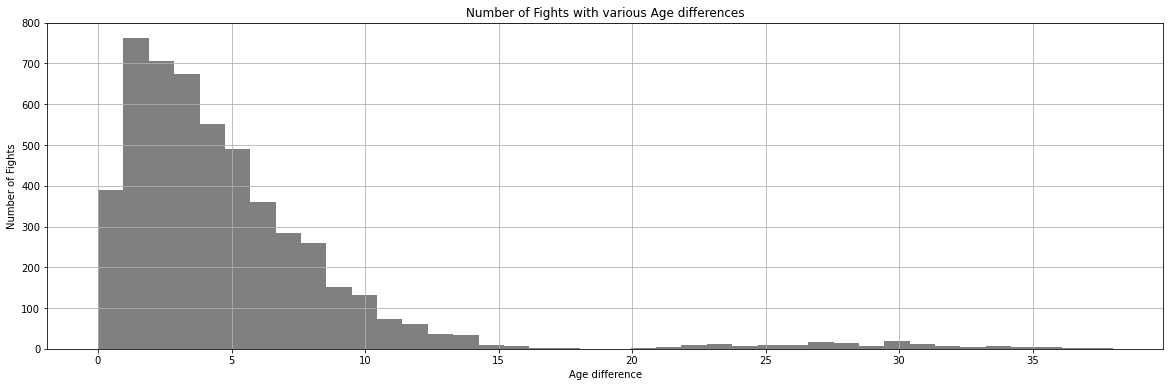

In [17]:
plt.figure(figsize=(20,6))
ufc_gen.Age_diff.hist(bins = 40, color = 'grey')
plt.xlabel('Age difference')
plt.ylabel('Number of Fights')
plt.title('Number of Fights with various Age differences')
plt.show()

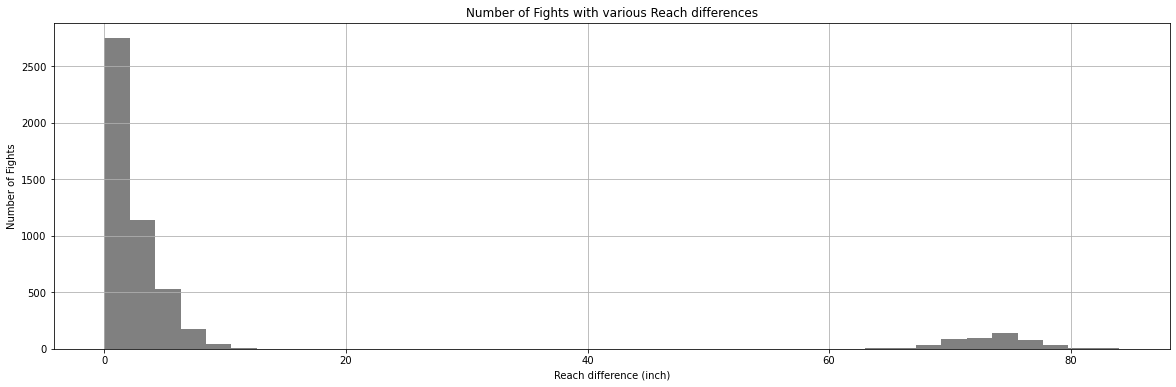

In [18]:
plt.figure(figsize=(20,6))
ufc_gen.Reach_diff_ins.hist(bins = 40, color = 'grey')
plt.xlabel('Reach difference (inch)')
plt.ylabel('Number of Fights')
plt.title('Number of Fights with various Reach differences')
plt.show()

*Similar curve, similar values - wouldn't it be enough to include only one of them (either age or reach difference)?*

### 2.13 Fighter Features.

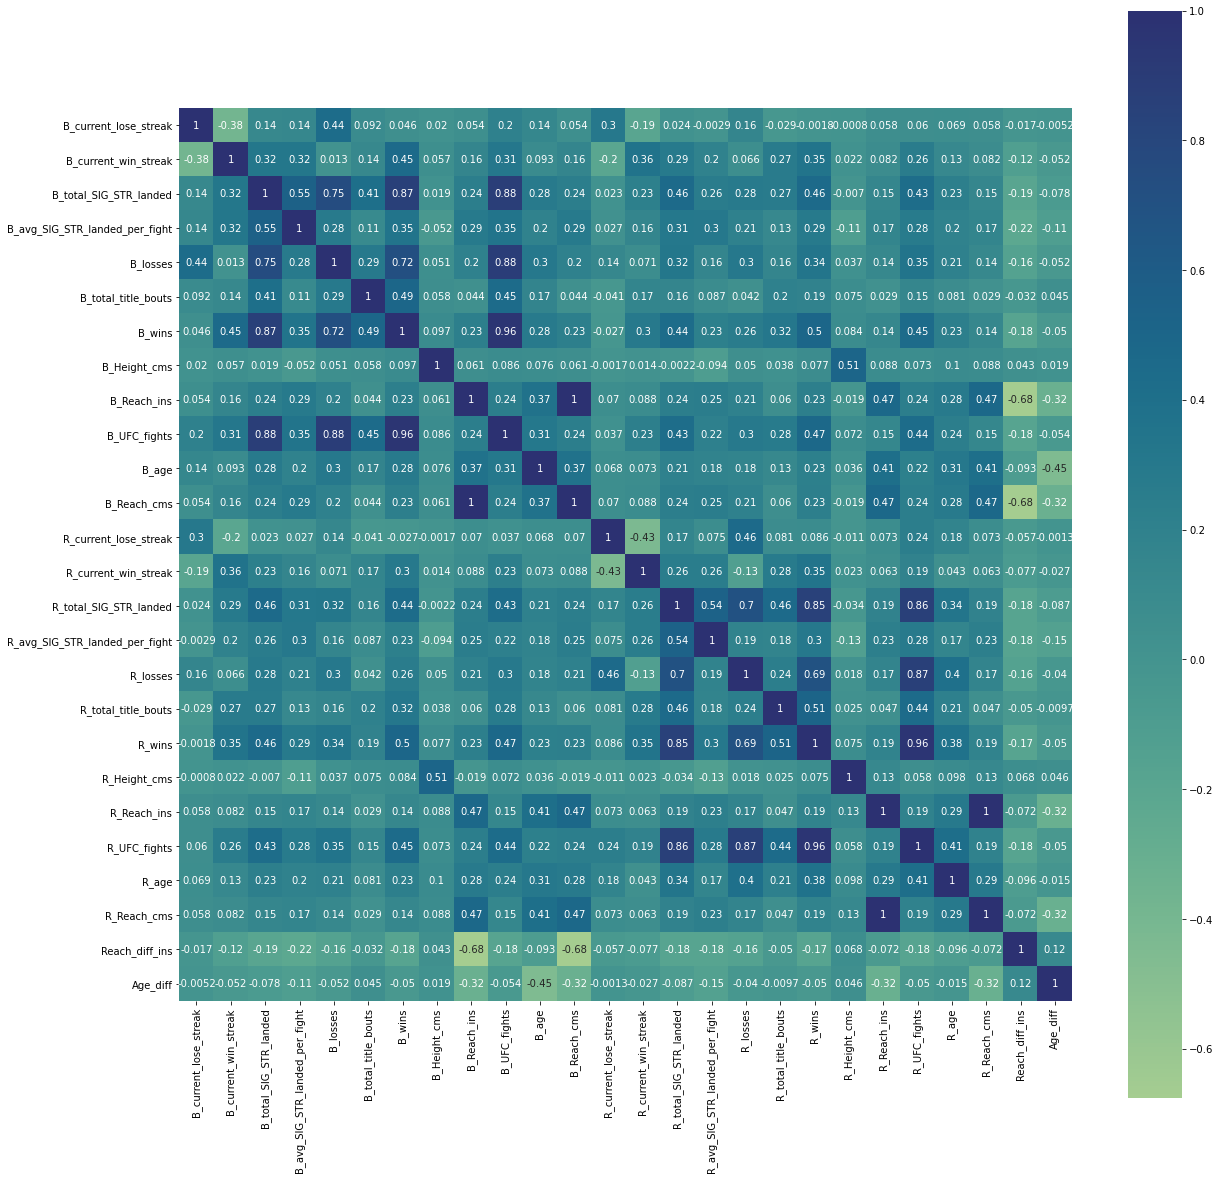

In [19]:
corr_features = ['B_current_lose_streak', 'B_current_win_streak', 'B_total_SIG_STR_landed',
                'B_avg_SIG_STR_landed_per_fight', 'B_losses', 'B_total_title_bouts',
                 'B_wins', 'B_Height_cms', 'B_Reach_ins', 'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
                 'R_current_win_streak', 'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
                 'R_total_title_bouts', 'R_wins', 'R_Height_cms', 'R_Reach_ins', 'R_UFC_fights', 'R_age', 'R_Reach_cms',
                 'Reach_diff_ins', 'Age_diff']
corr = ufc_df[corr_features].corr(method='pearson')

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, square= True, annot = True, cmap = cmap)
plt.savefig('heatmap.png')

- height & reach are highly correlated, we could keep only one of them (as we included reach difference, i think we should keep reach difference)

# 3. Data Pre-processing.

### 4.1 Drop unnecessary columns & drop fights that ended in a draw.

In [20]:
ufc_df = ufc_df.drop(labels = ['R_fighter', 'B_fighter', 'location',
       'Referee', 'date', 'R_odds', 'B_odds', 'R_Weight_lbs', 'B_Weight_lbs', 'no_of_rounds'], axis = 1)

ufc_df = ufc_df.drop(ufc_df[ufc_df.Winner == 'Draw'].index)

### 4.2 Deal with nominal features.

In [21]:
# one hot encoding
onehot_columns = ['weight_class', 'R_Stance', 'B_Stance']

ufc_ohe = pd.get_dummies(ufc_df, columns = onehot_columns, drop_first=True)
ufc_ohe.head()

,Unnamed: 0,R_odds_dec,B_odds_dec,Winner,title_bout,B_current_lose_streak,B_current_win_streak,B_avg_KD,B_SLpM,B_SApM,...,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch
0,0,2.450000,1.606061,Red,True,0,4,0.800000,3.233190,2.603720,...,0,1,0,0,0,0,1,0,0,0
1,1,1.090909,8.000000,Red,True,0,3,0.000000,3.625442,3.427562,...,0,0,0,1,0,0,1,0,0,0
2,2,1.476190,2.750000,Red,False,0,3,0.645161,4.823151,4.623572,...,0,1,0,0,0,0,1,0,0,0
3,3,4.000000,1.277778,Blue,False,0,4,0.500000,6.464724,2.921779,...,0,1,0,0,0,0,0,0,0,1
4,4,1.625000,2.400000,Blue,False,0,1,0.000000,3.075000,4.500000,...,0,0,0,1,0,0,0,0,1,0


In [22]:
ufc_ohe.columns

Index(['Unnamed: 0', 'R_odds_dec', 'B_odds_dec', 'Winner', 'title_bout',
       'B_current_lose_streak', 'B_current_win_streak', 'B_avg_KD', 'B_SLpM',
       'B_SApM', 'B_Sd', 'B_total_SIG_STR_landed',
       'B_avg_SIG_STR_landed_per_fight', 'B_losses',
       'B_avg_SIG_STR_absorberd_per_fight', 'B_total_SIG_STR_absorbed',
       'B_avg_opp_TOTAL_STR_landed', 'B_total_rounds_fought',
       'B_total_time_fought(minutes)', 'B_total_time_fought(seconds)',
       'B_avg_time_fought_per_fight(seconds)', 'B_total_title_bouts',
       'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Height_cms', 'B_Reach_ins',
       'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
       'R_current_win_streak', 'R_avg_KD', 'R_SLpM', 'R_SApM', 'R_Sd',
       'R_total_SIG_STR_absorbed', 'R_total_SIG_STR_landed',
       'R_avg_SIG_STR_landed_per_fight', '

In [23]:
X = ufc_ohe[['title_bout',
       'B_current_lose_streak', 'B_current_win_streak', 'B_avg_KD', 'B_SLpM',
       'B_SApM', 'B_Sd', 'B_total_SIG_STR_landed',
       'B_avg_SIG_STR_landed_per_fight', 'B_losses',
       'B_avg_SIG_STR_absorberd_per_fight', 'B_total_SIG_STR_absorbed',
       'B_avg_opp_TOTAL_STR_landed', 'B_total_rounds_fought',
       'B_total_time_fought(minutes)', 'B_total_time_fought(seconds)',
       'B_avg_time_fought_per_fight(seconds)', 'B_total_title_bouts',
       'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Height_cms', 'B_Reach_ins',
       'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
       'R_current_win_streak', 'R_avg_KD', 'R_SLpM', 'R_SApM', 'R_Sd',
       'R_total_SIG_STR_absorbed', 'R_total_SIG_STR_landed',
       'R_avg_SIG_STR_landed_per_fight', 'R_losses',
       'R_avg_SIG_STR_absorbed_per_fight', 'R_avg_opp_TOTAL_STR_landed',
       'R_total_rounds_fought', 'R_total_time_fought(minutes)',
       'R_total_time_fought(seconds)', 'R_avg_time_fought_per_fight(seconds)',
       'R_total_title_bouts', 'R_win_by_Decision_Majority',
       'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
       'R_win_by_KO/TKO', 'R_win_by_Submission',
       'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Height_cms', 'R_Reach_ins',
       'R_Reach_cms', 'R_UFC_fights', 'R_age', 'Reach_diff_ins', 'Age_diff',
       'weight_class_Catch Weight', 'weight_class_Featherweight',
       'weight_class_Flyweight', 'weight_class_Heavyweight',
       'weight_class_Light Heavyweight', 'weight_class_Lightweight',
       'weight_class_Middleweight', 'weight_class_Open Weight',
       'weight_class_Welterweight', 'weight_class_Women\'s Bantamweight',
       'weight_class_Women\'s Featherweight', 'weight_class_Women\'s Flyweight',
       'weight_class_Women\'s Strawweight', 'R_Stance_Open Stance',
       'R_Stance_Orthodox', 'R_Stance_Sideways', 'R_Stance_Southpaw',
       'R_Stance_Switch', 'B_Stance_Open Stance', 'B_Stance_Orthodox',
       'B_Stance_Sideways', 'B_Stance_Southpaw', 'B_Stance_Switch']]
y = ufc_ohe['Winner']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5061, 84)
y shape: (5061,)


### 4.7 Select the 20 most influential features & select the best features.

In [24]:
# selecting best features
#print(X.shape)

k_best = SelectKBest(k = 20)
k_best.fit(X, y)
X_train_k_best = k_best.transform(X)
# X_test_k_best = k_best.transform(X)

#print(X_train_k_best.shape)
#print(X.columns[k_best.get_support()])

best_features = X.columns[k_best.get_support()]

#warnings.filterwarnings("ignore")

X = ufc_ohe[best_features]
y = ufc_ohe['Winner']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5061, 20)
y shape: (5061,)


In [25]:
# define the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### 4.5 Deal with numerical features.

In [26]:
# scale_columns = ['B_current_lose_streak', 'B_current_win_streak', 'B_total_SIG_STR_landed',
#                'B_avg_SIG_STR_landed_per_fight', 'B_losses', 'B_total_title_bouts',
#                 'B_wins', 'B_Height_cms', 'B_Reach_ins', 'B_UFC_fights', 'B_age', 'B_Reach_cms', 'R_current_lose_streak',
#                 'R_current_win_streak', 'R_total_SIG_STR_landed', 'R_avg_SIG_STR_landed_per_fight', 'R_losses',
#                 'R_total_title_bouts', 'R_wins', 'R_Height_cms', 'R_Reach_ins', 'R_UFC_fights', 'R_age', 'R_Reach_cms',
#                 'Reach_diff_ins', 'Age_diff']

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

#warnings.filterwarnings("ignore")

# 5. Machine Learning Models.

### 5.1 Build models.

In [27]:
# knn
knn = KNeighborsClassifier()

# neural network
mpl = MLPClassifier()

# decision tree
tree = DecisionTreeClassifier()

# random forest
forest = RandomForestClassifier()

classifiers = (knn, mpl, tree, forest)

### 5.2 Build the 'applyModel' function.

In [28]:
def applyModel(model,name,X_train, y_train, X_test, y_test):
    m = model.fit(X_train,y_train)
    print(name, '- Training accuracy:', m.score(X_train, y_train))
    print(name, '- Testing accuracy:', m.score(X_test, y_test))

### 5.3 Train and test with the different models.

In [29]:
for c in classifiers:
    n = str(c)
    applyModel(c, n, X_train, y_train, X_test, y_test)
    print('')
    
warnings.filterwarnings("ignore")

KNeighborsClassifier() - Training accuracy: 0.7702239789196311
KNeighborsClassifier() - Testing accuracy: 0.6579778830963665



C:\Users\gusta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier() - Training accuracy: 0.7085638998682477
MLPClassifier() - Testing accuracy: 0.7109004739336493

DecisionTreeClassifier() - Training accuracy: 0.9965744400527009
DecisionTreeClassifier() - Testing accuracy: 0.617693522906793

RandomForestClassifier() - Training accuracy: 0.9965744400527009
RandomForestClassifier() - Testing accuracy: 0.6729857819905213



### Prinipal component analysis (PCA)

In [30]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [31]:
principalDf

,principal component 1,principal component 2
0,3990.625527,-92.289801
1,4019.624094,425.956335
2,5654.371663,-49.965194
3,2094.374561,177.309192
4,-1672.543716,729.151826
...,...,...
5056,-3454.738746,-247.441057
5057,-3487.829701,-493.004943
5058,-3488.216000,-496.874815
5059,-3488.230569,-496.912795


In [32]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [33]:
finalDf

,principal component 1,principal component 2,Winner
0,3990.625527,-92.289801,Red
1,4019.624094,425.956335,Red
2,5654.371663,-49.965194,Red
3,2094.374561,177.309192,Blue
4,-1672.543716,729.151826,Blue
...,...,...,...
5139,NaN,NaN,Red
5140,NaN,NaN,Red
5141,NaN,NaN,Red
5142,NaN,NaN,Red


In [34]:
# explained of the variance. We can see that the first explains most of the variance 
pca.explained_variance_ratio_

array([0.98657802, 0.0075621 ])

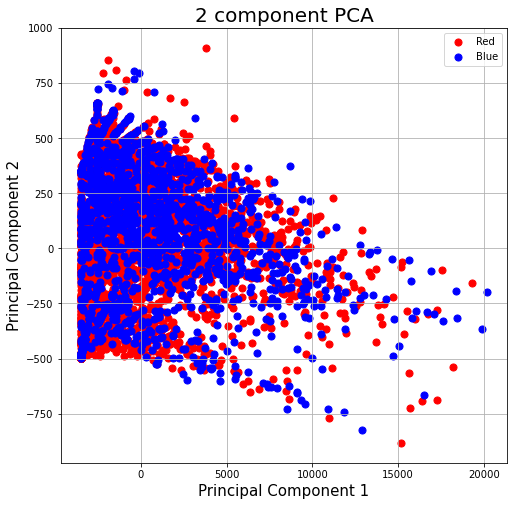

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Red', 'Blue']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Winner'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### Heatmap of components 

In [36]:
pca.components_

array([[ 1.69248226e-03,  2.45909106e-02,  1.57758403e-03,
         4.00706342e-03,  6.92922155e-05,  4.36094909e-02,
         5.28202228e-02,  4.64392173e-04,  1.56560785e-03,
         2.23282760e-03,  3.60708688e-03,  1.66079935e-02,
         9.96479612e-01,  3.74859943e-02,  8.41717440e-05,
         8.57879937e-04,  2.17901503e-03,  1.37620054e-03,
         5.60369402e-04, -1.05066679e-03],
       [ 4.60709980e-02,  9.22910415e-01,  1.85193450e-02,
         4.70391361e-02,  1.12322292e-03,  3.58237260e-03,
         7.12009471e-03, -3.49492365e-04,  1.79833603e-02,
         2.73197494e-02, -4.64695744e-04, -6.30694469e-04,
        -3.78416681e-02,  3.74543225e-01,  6.65136533e-05,
         8.75899401e-03,  2.22478446e-02, -5.63833739e-04,
         1.46076370e-03, -1.15811661e-02]])

<AxesSubplot:xlabel='None'>

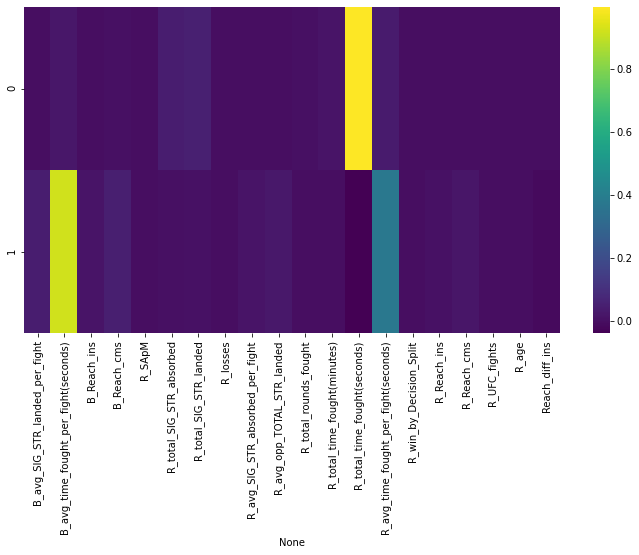

In [37]:
map = pd.DataFrame(pca.components_,columns=[best_features])
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='viridis')

### Fit the PCA model & transform the X_train & and X_test

In [38]:
pca.fit(X_train)

PCA(n_components=2)

In [39]:
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

### Testing neural network & Random Forest on PCA transformed data

In [ ]:
mlp = MLPClassifier(alpha=4, learning_rate="invscaling")

mlp.fit(X_train, y_train)

print('Decision KNeighborsClassifier, Cancer dataset, weights set to "distance", and 5 neighbors')
print('Accuracy on the training set: {:.3f}'.format(mlp.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(mlp.score(X_test, y_test)))

In [ ]:
knn = RandomForestClassifier(max_depth=6, criterion='entropy')

knn.fit(pca_train, y_train)

print('Decision KNeighborsClassifier, Cancer dataset, weights set to "distance", and 5 neighbors')
print('Accuracy on the training set: {:.3f}'.format(knn.score(pca_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(knn.score(pca_test, y_test)))

### 5.4 Play around with KNN on normal X_train,X_test, y_train, & y_test

In [ ]:
training_accuracy = []
testing_accuracy = []
number_of_neighbors =[]
weighting_choice = []

weight_values = ['distance', 'uniform']

for n_neighbors in range(1,100):
    for weights in weight_values:
        clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
        clf.fit(X_train, y_train)
        training_accuracy.append(clf.score(X_train, y_train))
        testing_accuracy.append(clf.score(X_test, y_test))
        number_of_neighbors.append(n_neighbors)
        weighting_choice.append(weights)
      
     
combinations_sorted_knn = sorted(list(zip(number_of_neighbors, weighting_choice, training_accuracy, testing_accuracy)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n')
print(*combinations_sorted_knn[0:5], sep = "\n")

# save the best variables
knn_best_n_neighbors = combinations_sorted_knn[0][0]
knn_best_weights = combinations_sorted_knn[0][1]

#### 5.4.1 KNN - Cross validation

In [ ]:
#We define the parameters which want to test for the KNN model
param_grid = {
    "n_neighbors": [32,54,74,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhatten"], "leaf_size": [10,30,60]
}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_
    # ,"\n best parameters: ", gs_result.best_params_
)

print("Test score: ", grid_search.score(X_test,y_test))


### 5.5 Play around with Neural Network.

In [ ]:
train_acc = []
test_acc = []
alpha_value = []
learning_rate_value = []
hidden_layer_sizes_value = []


alphas = (0.0001, 0.001, 0.1, 0, 1, 5, 100)
learning_rates = ('constant', 'invscaling', 'adaptive')
hidden_layer_sizes = (1,10,50,100,200,250,300)

for a in alphas:
    for l in learning_rates:
        for f in hidden_layer_sizes:
            mpl = MLPClassifier(alpha=a, learning_rate = l, hidden_layer_sizes = f)
            mpl.fit(X_train, y_train)
            train_acc.append(accuracy_score(mpl.predict(X_train), y_train))
            test_acc.append(accuracy_score(mpl.predict(X_test), y_test))
            alpha_value.append(a)
            learning_rate_value.append(l)
            hidden_layer_sizes_value(f)
            
        

combinations_sorted_mpl = sorted(list(zip(alpha_value, learning_rate_value, train_acc, test_acc)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n')
print(*combinations_sorted_mpl[0:5], sep = "\n")

# save the best variables
mpl_best_alpha = combinations_sorted_knn[0][0]
mpl_best_learning_rate = combinations_sorted_knn[0][1]

#### Neural Network - Cross validation

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {"learning_rate":["constant", "invscaling", "adaptive"], "alpha":[0.01,0.01,1,5,10,15]}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test))

### 5.6 Play around with Decision Tree.

In [ ]:
train_acc = []
test_acc = []
max_depth_value = []

for i in range(1,30):
    dt = DecisionTreeClassifier(max_depth = i, random_state=0)
    dt.fit(X_train, y_train)
    train_acc.append(accuracy_score(dt.predict(X_train), y_train))
    test_acc.append(accuracy_score(dt.predict(X_test), y_test))
    max_depth_value.append(i)

combinations_sorted_tree = sorted(list(zip(max_depth_value, train_acc, test_acc)), key = lambda e:e[2], reverse = True)

print('Top 5 results, sorted by test accuracy:\n   (Values: depth, training accracy, test accuracy)\n')
print(*combinations_sorted_tree[0:5], sep = "\n")

# save the best variable
tree_best_max_depth = combinations_sorted_tree[0][0]

##### 5.6.1 Decision Tree - Cross validation

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20]}

#We make the model with cross validation and grid search
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test)
)

### 5.7 Play around with Random Forest.

In [ ]:
train_acc = []
test_acc = []
max_depth_value = []
criterion_value = []
max_features_value = []

criterions = ('gini', 'entropy')
number_of_features = range(1,6)

for i in range(1,9):
    for c in criterions:
        for f in number_of_features:
                rf = RandomForestClassifier(criterion = c, max_depth = i, max_features = f, random_state=0)
                rf.fit(X_train, y_train)
                train_acc.append(accuracy_score(rf.predict(X_train), y_train))
                test_acc.append(accuracy_score(rf.predict(X_test), y_test))
                max_depth_value.append(i)
                criterion_value.append(c)
                max_features_value.append(f)

combinations_sorted_forest = sorted(list(zip(max_features_value, criterion_value, max_depth_value, train_acc, test_acc)), key = lambda e:e[3], reverse = True)

print('Top 5 results, sorted by test accuracy:\n   (Values: depth, training accracy, test accuracy)\n')
print(*combinations_sorted_forest[0:5], sep = "\n")

# save the best variable


#### Random forest - Cross validation 

In [ ]:
#We define the parameters which want to test for the decision tree model
param_grid = {
    "max_features":[2,4,6,8,10,12,20,40], 'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20], "criterion":['gini', 'entropy']
             }

#We make the model with cross validation and grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)

#We fit the model, with the best parameters: 
gs_result = grid_search.fit(X_train, y_train)

#print the results: 

print(
    "\n Training score: ", gs_result.best_score_, 
    "\n Best estimator: ", gs_result.best_estimator_,
    "\n best parameters: ", gs_result.best_params_,
    "Test score: ", grid_search.score(X_test,y_test)
)

### 5.8 Look at the best combinations with each model.

In [ ]:
print('KNN:', combinations_sorted_knn[0])
print('Neural Network:', combinations_sorted_mpl[0])
print('Decision Tree:', combinations_sorted_tree[0])
print('Random Forest:', combinations_sorted_forest[0])

best_combos = {'kNN': combinations_sorted_knn[0][-1], 'Neural Network': combinations_sorted_mpl[0][-1], 'Decision Tree': combinations_sorted_tree[0][-1], 'Random Forest': combinations_sorted_forest[0][-1]}
# for now, the KNN model has the highest test accuracy

In [ ]:
keys = list(best_combos.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(best_combos[k]) for k in keys]

splot = sns.barplot(x = keys, y = vals, palette = ['Grey', 'Red', 'Grey', 'Grey'])

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'top', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

### Final model and predictions on historical data to check profitability 

In [40]:
mlp_model = MLPClassifier(alpha=0.01, learning_rate="invscaling")
mlp_model.fit(X_train,y_train)
mlp_model_score = mlp_model.score(X_train,y_train)
mlp__model_test = mlp_model.score(X_test,y_test)


print("accuracy train {:.3f}  test {:.3f}".format(mlp_model_score, mlp__model_test))


accuracy train 0.700  test 0.711


In [41]:
X["predictions"] = mlp_model.predict(X)

In [42]:
X["winner"] = y

In [43]:
#import the odds
df_odds = pd.read_excel('newestdataset_odds.xlsx')

In [44]:
df_odds

,Unnamed: 0,R_odds_dec,B_odds_dec,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,...,R_Height_cms,R_Reach_ins,R_Reach_cms,R_Weight_lbs,R_UFC_fights,R_age,Reach_diff_ins,Age_diff,R_odds,B_odds
0,0,2.450000,1.606061,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,...,162.56,64.000000,162.56,135.0,10,32.0,3.0,1,145.0,-165.0
1,1,1.090909,8.000000,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,...,165.10,66.000000,167.64,125.0,7,31.0,0.0,1,-1100.0,700.0
2,2,1.476190,2.750000,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,...,180.34,76.000001,193.04,155.0,15,35.0,3.0,1,-210.0,175.0
3,3,4.000000,1.277778,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,...,162.56,68.000000,172.72,135.0,8,29.0,1.0,3,300.0,-360.0
4,4,1.625000,2.400000,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,...,187.96,75.000000,190.50,264.0,4,26.0,2.0,6,-160.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5139,5139,NaN,NaN,Gerard Gordeau,Kevin Rosier,Joao Alberto Barreto,1993-11-12,"Denver, Colorado, USA",Red,False,...,195.58,0.000000,NaN,216.0,1,34.0,0.0,34,NaN,NaN
5140,5140,NaN,NaN,Ken Shamrock,Patrick Smith,Joao Alberto Barreto,1993-11-12,"Denver, Colorado, USA",Red,False,...,185.42,72.000000,182.88,205.0,0,29.0,72.0,1,NaN,NaN
5141,5141,NaN,NaN,Royce Gracie,Art Jimmerson,Joao Alberto Barreto,1993-11-12,"Denver, Colorado, USA",Red,False,...,185.42,0.000000,NaN,175.0,0,26.0,0.0,4,NaN,NaN
5142,5142,NaN,NaN,Kevin Rosier,Zane Frazier,Joao Alberto Barreto,1993-11-12,"Denver, Colorado, USA",Red,False,...,193.04,0.000000,NaN,275.0,0,NaN,0.0,0,NaN,NaN


In [45]:
df_odds[["R_odds_dec", "B_odds_dec"]]

,R_odds_dec,B_odds_dec
0,2.450000,1.606061
1,1.090909,8.000000
2,1.476190,2.750000
3,4.000000,1.277778
4,1.625000,2.400000
...,...,...
5139,NaN,NaN
5140,NaN,NaN
5141,NaN,NaN
5142,NaN,NaN


In [46]:
df_odds["R_odds_dec"] = df_odds["R_odds_dec"].fillna(df_odds["R_odds_dec"].mean())
df_odds["B_odds_dec"] = df_odds["B_odds_dec"].fillna(df_odds["B_odds_dec"].mean())

In [47]:
df_odds[["R_odds_dec", "B_odds_dec"]]

,R_odds_dec,B_odds_dec
0,2.450000,1.606061
1,1.090909,8.000000
2,1.476190,2.750000
3,4.000000,1.277778
4,1.625000,2.400000
...,...,...
5139,1.965412,2.716405
5140,1.965412,2.716405
5141,1.965412,2.716405
5142,1.965412,2.716405


In [48]:
# Drop the draw fights to get equal shape between odds and X. We need to remeber to substact this from the profit. 
df_odds = df_odds.drop(df_odds[df_odds.Winner == 'Draw'].index)

In [49]:
# We will determine the winnings bets. 
X["winner_bet"] =  np.where(X["winner"] == "Red", df_odds["R_odds_dec"], df_odds["B_odds_dec"])

In [50]:
# If the prediction is correct return 1 else -1
X["comparison_column"] = np.where(X["predictions"] == X["winner"], 1*X["winner_bet"], -1)

In [51]:
# we calculate the profit with 100 DKK per fight
X["profit"] = np.where(X["comparison_column"] > 0, (X["comparison_column"]*100)-100, -1*100) 

In [52]:
X["profit"]

0       145.000000
1         9.090909
2        47.619048
3      -100.000000
4      -100.000000
           ...    
5139     96.541162
5140     96.541162
5141   -100.000000
5142     96.541162
5143   -100.000000
Name: profit, Length: 5061, dtype: float64

In [53]:
print("profit :")
X["profit"].sum()

profit :


115118.04164141457

In [54]:
#if our initial investment is 514 300 the percentage increase in portofolio is: 
((( X["profit"].sum()) / (5143*100)))*100

22.38344189022255

In [55]:
X.to_excel("output_with_predictions_and_profit.xlsx") 